# 题目要求
本次任务的目的是处理PO2，PCO2两个指标。这两个指标均为病人的血气指标，以一定的时间间隔采集。一个病人一次住院期间可能收集一次或者多次。要求，按照采集时间的前后顺序，汇总每个病人每次住院期间的所有的pO2, pCO2指标值。涉及到的预处理方法包括插值，去噪，缺失值填充，离群点数据处理，可视化等。

# 数据集说明
patients:包含所有患者数据。

chart_events：包含了所有可供患者使用的图表数据。在他们的ICU停留期间，病人信息的主要存储库是他们的电子图表。电子图表显示病人的日常生命体征和与他们的护理有关的任何额外信息：呼吸机设置、实验室值、代码状态、精神状态等等。因此，关于病人住院的大部分信息都包含在chartevent中。此外，即使在其他地方捕获了实验室值（labevent），它们也经常在chartevent中重复。这是因为在病人的电子图上显示实验室值是可取的，因此这些值是从存储实验室值的数据库复制到存储chartevent的数据库中。当labevent中的值与chartevent中的值不同时，以labevent中的值为准。

label_events：实验检查信息表，主要是患者的实验室检测记录信息


# 导库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 基本设置

In [2]:
# 设置可视化风格
plt.style.use('tableau-colorblind10')
# 设置字体为SimHei(黑体)
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决中文字体下坐标轴负数的负号显示问题
plt.rcParams['axes.unicode_minus'] = False

# 数据提取

## 提取LABEVENTS表格中PO2和PCO2数据

In [3]:
# 根据采集时间来读取数据
df = pd.read_csv('mini_label_events.csv', index_col='CHARTTIME')

In [4]:
# 筛选出po2和pco2数据
po2 = df.query('ITEMID==490 | ITEMID==3785 | ITEMID==3837 | ITEMID==50821')
pco2 = df.query('ITEMID==3784 | ITEMID==3835 | ITEMID==50818')

In [5]:
# 创建DateFrame来存储数据
a1 = pd.DataFrame()
a1["PO2"] = po2["VALUENUM"]
a1["PCO2"] = pco2["VALUENUM"]
a1["SUBJECT_ID"] = po2["SUBJECT_ID"]
a1["HADM_ID1"] = po2["HADM_ID"]
a1['采集时间'] = a1.index

In [6]:
# 重置索引
a1.reset_index()
# 根据采集时间从早到晚进行排序
a1.sort_values("CHARTTIME", inplace=True)
# 插入序号并设为索引
a1.insert(0, '序号', range(1, 1 + len(a1)))
a1.set_index('序号', inplace=True)
a1

,PO2,PCO2,SUBJECT_ID,HADM_ID1,采集时间
序号,,,,,
1,186.0,32.0,60207,164814.0,2101-07-19 14:56:00
2,173.0,33.0,60207,164814.0,2101-07-19 22:07:00
3,194.0,29.0,60207,164814.0,2101-07-20 05:29:00
4,239.0,37.0,1205,152970.0,2101-12-20 09:03:00
5,129.0,40.0,1205,152970.0,2101-12-20 11:33:00
...,...,...,...,...,...
4669,88.0,28.0,24851,111571.0,2199-01-25 09:41:00
4670,35.0,41.0,24851,111571.0,2199-01-30 05:08:00
4671,65.0,36.0,23765,193447.0,2200-05-08 19:52:00


## 提取CHARTEVENTS表格中PO2和PCO2数据

In [7]:
df2 = pd.read_csv('mini_chart_events.csv',
                  low_memory=False, index_col="CHARTTIME")

In [8]:
# 筛选出po2和pco2数据
po2 = df2.query('ITEMID==490 | ITEMID==3785 | ITEMID==3837 | ITEMID==50821')
pco2 = df2.query('ITEMID==3784 | ITEMID==3835 | ITEMID==50818')
# 这里存在重复时间索引，删除前面一个，保留最后一个
po2 = po2.reset_index().drop_duplicates(
    subset='CHARTTIME', keep='last').set_index('CHARTTIME')
pco2 = pco2.reset_index().drop_duplicates(
    subset='CHARTTIME', keep='last').set_index('CHARTTIME')

In [9]:
# 创建DateFrame来存储数据
a2 = pd.DataFrame()
a2["PO2"] = po2["VALUENUM"]
a2["PCO2"] = pco2["VALUENUM"]
a2["SUBJECT_ID"] = po2["SUBJECT_ID"]
a2["HADM_ID1"] = po2["HADM_ID"]
a2['采集时间'] = a2.index

In [10]:
# 重置索引
a2.reset_index()
# 根据采集时间从早到晚进行排序
a2.sort_values("CHARTTIME", inplace=True)
# 插入序号并设为索引
a2.insert(0, '序号', range(1, 1 + len(a2)))
a2.set_index('序号', inplace=True)
a2

,PO2,PCO2,SUBJECT_ID,HADM_ID1,采集时间
序号,,,,,
1,NaN,NaN,13081,120737,2102-01-11 06:00:00
2,257.200012,NaN,32476,119862,2109-05-30 18:59:00
3,54.000000,47.0,30712,167392,2111-02-22 19:23:00
4,68.000000,47.0,30712,167392,2111-02-22 23:32:00
5,42.000000,42.0,30712,167392,2111-02-23 06:23:00
...,...,...,...,...,...
132,49.000000,39.0,9557,178366,2195-08-07 12:00:00
133,NaN,NaN,9557,178366,2195-08-10 12:00:00
134,228.199997,NaN,12183,180744,2197-06-03 03:00:00


# 最小采集时间的间隔

In [11]:
# 根据病人ID和不同住院时间的ID进行分组
group = a1.groupby(["SUBJECT_ID", "HADM_ID1"])

In [12]:
# 提取采集时间大于1的组别(只有2个时间以上才能求间隔)
tem_list = []
for key, item in group['采集时间']:
    if item.count() > 1:
        tem_list.append(item)

In [13]:
# 提取各组的所有采集时间间隔
interval_list = []
for i in range(len(tem_list)):
    tem_list[i].sort_values(ascending=False, inplace=True)  # 对采集时间进行从大到小的排序
    for j in range(tem_list[i].count() - 1):
        interval = pd.to_datetime(
            tem_list[i].iloc[j]) - pd.to_datetime(tem_list[i].iloc[j+1])
        interval_list.append(interval)

In [14]:
# 选取最小的时间间隔
min(interval_list)

Timedelta('0 days 00:01:00')

可以发现，最小的采集时间间隔为1分钟，下面就利用该时间来进行插值

# 插值
pandas 插值核心函数为interpolate()

可选的插值方式有：

nearest：最邻近插值法

zero：阶梯插值

slinear、linear：线性插值

quadratic、cubic：2、3阶B样条曲线插值

## 对LABEVENTS表格中PO2和PCO2数据进行插值

In [15]:
ipl = pd.DataFrame()  # 用来存储插值后的结果

In [16]:
for key, item in group:
    item.set_index('采集时间', inplace=True)
    item.index = pd.to_datetime(item.index)
    # 设置重采样时间间隔为1min，该时间由上面选取得到
    ev_ipl = item.resample('1min').interpolate()  # 这里使用默认的线性插值
    ipl = pd.concat([ipl, ev_ipl], axis=0)

In [17]:
# 重置索引
ipl.reset_index(inplace=True)
# 插入序号并设为索引
ipl.insert(0, '序号', range(1, 1 + len(ipl)))
ipl.set_index('序号', inplace=True)
# 更换顺序
order = ['PO2', 'PCO2', 'SUBJECT_ID', 'HADM_ID1', '采集时间']
ipl = ipl[order]
ipl

,PO2,PCO2,SUBJECT_ID,HADM_ID1,采集时间
序号,,,,,
1,63.000000,48.000000,127.0,141647.0,2183-08-21 10:26:00
2,347.000000,57.000000,273.0,158689.0,2141-04-19 05:26:00
3,346.573604,56.994924,273.0,158689.0,2141-04-19 05:27:00
4,346.147208,56.989848,273.0,158689.0,2141-04-19 05:28:00
5,345.720812,56.984772,273.0,158689.0,2141-04-19 05:29:00
...,...,...,...,...,...
2365510,56.030810,37.997630,99863.0,100749.0,2142-04-24 17:46:00
2365511,56.023108,37.998222,99863.0,100749.0,2142-04-24 17:47:00
2365512,56.015405,37.998815,99863.0,100749.0,2142-04-24 17:48:00


## 对CHARTEVENTS表格中PO2和PCO2数据进行插值

In [18]:
ipl2 = pd.DataFrame()  # 用来存储插值后的结果

In [19]:
# 根据病人ID和不同住院时间的ID进行分组
group2 = a2.groupby(["SUBJECT_ID", "HADM_ID1"])
for key, item in group2:
    item.set_index('采集时间', inplace=True)
    item.index = pd.to_datetime(item.index)
    # 设置重采样时间间隔为1min，该时间由上面选取得到
    ev_ipl = item.resample('1min').interpolate()  # 这里使用默认的线性插值
    ipl2 = pd.concat([ipl2, ev_ipl], axis=0)

In [20]:
# 重置索引
ipl2.reset_index(inplace=True)
# 插入序号并设为索引
ipl2.insert(0, '序号', range(1, 1 + len(ipl2)))
ipl2.set_index('序号', inplace=True)
# 更换顺序
order = ['PO2', 'PCO2', 'SUBJECT_ID', 'HADM_ID1', '采集时间']
ipl2 = ipl2[order]
ipl2

,PO2,PCO2,SUBJECT_ID,HADM_ID1,采集时间
序号,,,,,
1,257.200012,NaN,907.0,149649.0,2155-08-21 19:00:00
2,308.500000,NaN,946.0,183564.0,2120-05-05 05:00:00
3,308.491890,NaN,946.0,183564.0,2120-05-05 05:01:00
4,308.483781,NaN,946.0,183564.0,2120-05-05 05:02:00
5,308.475671,NaN,946.0,183564.0,2120-05-05 05:03:00
...,...,...,...,...,...
325115,61.022901,35.984733,30712.0,167392.0,2111-02-24 06:10:00
325116,61.015267,35.989822,30712.0,167392.0,2111-02-24 06:11:00
325117,61.007634,35.994911,30712.0,167392.0,2111-02-24 06:12:00


# 缺失点处理

## 对LABEVENTS表格中PO2和PCO2数据缺失点进行处理

In [22]:
# 检测PO2缺失值
ipl.loc[ipl["PO2"].isnull(), :]

,PO2,PCO2,SUBJECT_ID,HADM_ID1,采集时间
序号,,,,,


In [23]:
# 检测PCO2缺失值
ipl.loc[ipl["PCO2"].isnull(), :]

,PO2,PCO2,SUBJECT_ID,HADM_ID1,采集时间
序号,,,,,


LABEVENTS表格中PO2和PCO2数据均无缺失点，不进行处理。

## 对LABEVENTS表格中PO2和PCO2数据缺失点进行处理

In [24]:
# 检测PO2缺失值
ipl2.loc[ipl2["PO2"].isnull(), :]

,PO2,PCO2,SUBJECT_ID,HADM_ID1,采集时间
序号,,,,,
22158,NaN,NaN,7285.0,150783.0,2175-04-21 08:00:00
29662,NaN,NaN,13081.0,120737.0,2102-01-11 06:00:00
86560,NaN,NaN,18305.0,120110.0,2187-02-06 10:00:00


In [25]:
# 检测PCO2缺失值
ipl2.loc[ipl2["PCO2"].isnull(), :]

,PO2,PCO2,SUBJECT_ID,HADM_ID1,采集时间
序号,,,,,
1,257.200012,NaN,907.0,149649.0,2155-08-21 19:00:00
2,308.500000,NaN,946.0,183564.0,2120-05-05 05:00:00
3,308.491890,NaN,946.0,183564.0,2120-05-05 05:01:00
4,308.483781,NaN,946.0,183564.0,2120-05-05 05:02:00
5,308.475671,NaN,946.0,183564.0,2120-05-05 05:03:00
...,...,...,...,...,...
86557,249.199997,NaN,16378.0,179705.0,2134-03-15 19:00:00
86560,NaN,NaN,18305.0,120110.0,2187-02-06 10:00:00
270864,310.500000,NaN,20913.0,102847.0,2137-12-18 22:45:00


这里总共检测出7813条数据具有缺失值，将这些数据进行删除处理

In [26]:
ipl2.dropna(axis='index', how='any', inplace=True)  # any表示只要有一个缺失值则整行删除

处理后的数据如下表所示

In [27]:
ipl2

,PO2,PCO2,SUBJECT_ID,HADM_ID1,采集时间
序号,,,,,
7562,50.000000,58.000000,4033.0,196289.0,2159-06-15 01:00:00
7563,50.000000,58.000000,4033.0,196289.0,2159-06-15 01:01:00
7564,50.000000,58.000000,4033.0,196289.0,2159-06-15 01:02:00
7565,50.000000,58.000000,4033.0,196289.0,2159-06-15 01:03:00
7566,50.000000,58.000000,4033.0,196289.0,2159-06-15 01:04:00
...,...,...,...,...,...
325114,61.030534,35.979644,30712.0,167392.0,2111-02-24 06:09:00
325115,61.022901,35.984733,30712.0,167392.0,2111-02-24 06:10:00
325116,61.015267,35.989822,30712.0,167392.0,2111-02-24 06:11:00


# 去噪
在原始数据中添加了高斯白噪声，需要进行去噪。我选择删除偏离均值三倍标准差数据的方式进行去噪。

In [28]:
def drop_noisy(df):
    df_copy = df.copy()
    df_describe = df_copy.describe()
    for column in df.columns:
        mean = df_describe.loc['mean', column]
        std = df_describe.loc['std', column]
        minvalue = mean - 3*std
        maxvalue = mean + 3*std
        df_copy = df_copy[df_copy[column] >= minvalue]
        df_copy = df_copy[df_copy[column] <= maxvalue]
    return df_copy

## 对LABEVENTS表格中PO2和PCO2数据进行去噪

In [29]:
# 这里只对PO2和PCO2列进行去噪
dno1 = drop_noisy(ipl.iloc[:, :2])
dno1

,PO2,PCO2
序号,,
1,63.000000,48.000000
2,347.000000,57.000000
3,346.573604,56.994924
4,346.147208,56.989848
5,345.720812,56.984772
...,...,...
2365510,56.030810,37.997630
2365511,56.023108,37.998222
2365512,56.015405,37.998815


对PO2和PCO2去噪结果进行可视化展示

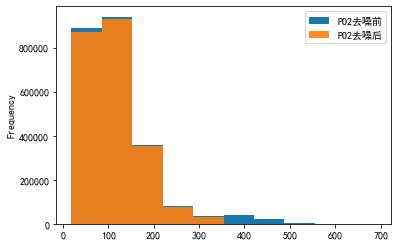

In [30]:
# PO2去噪前后可视化
plo1 = pd.DataFrame()
plo1['PO2去噪前'] = ipl['PO2']
plo1['PO2去噪后'] = dno1['PO2']
plo1.plot.hist(alpha=0.9)

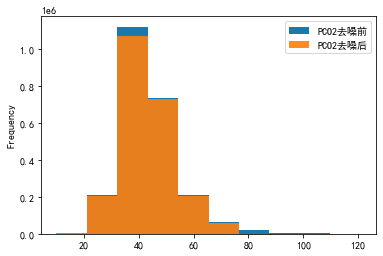

In [31]:
# PCO2去噪前后可视化
plo2 = pd.DataFrame()
plo2['PCO2去噪前'] = ipl['PCO2']
plo2['PCO2去噪后'] = dno1['PCO2']
plo2.plot.hist(alpha=0.9)

## 对CHARTEVENTS表格中PO2和PCO2数据进行去噪

In [32]:
dno2 = drop_noisy(ipl2.iloc[:, :2])
dno2

,PO2,PCO2
序号,,
7562,50.000000,58.000000
7563,50.000000,58.000000
7564,50.000000,58.000000
7565,50.000000,58.000000
7566,50.000000,58.000000
...,...,...
325114,61.030534,35.979644
325115,61.022901,35.984733
325116,61.015267,35.989822


对PO2和PCO2去噪结果进行可视化展示

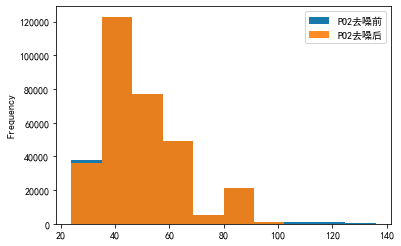

In [33]:
# PO2去噪前后可视化
plo3 = pd.DataFrame()
plo3['PO2去噪前'] = ipl2['PO2']
plo3['PO2去噪后'] = dno2['PO2']
plo3.plot.hist(alpha=0.9)

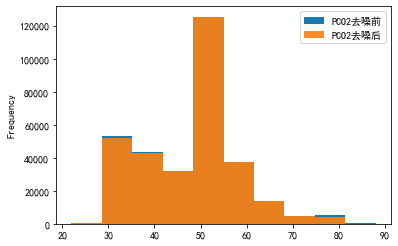

In [35]:
# PCO2去噪前后可视化
plo4 = pd.DataFrame()
plo4['PCO2去噪前'] = ipl2['PCO2']
plo4['PCO2去噪后'] = dno2['PCO2']
plo4.plot.hist(alpha=0.9)

# 离群点处理
通过绘制箱形图，将上边缘和下边缘之外的数据视作离群点，将其进行去除

## 对LABEVENTS表格中PO2和PCO2数据离群点进行处理

In [36]:
c = pd.DataFrame()
c['PO2'] = plo1['PO2去噪后']
c['PCO2'] = plo2['PCO2去噪后']

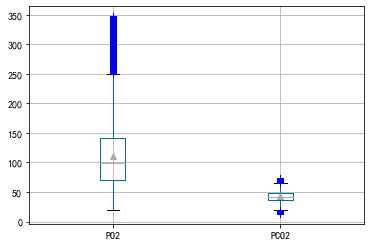

In [37]:
c.boxplot(showmeans=True, sym='b+')

对PO2数据进行处理，将箱体图上下边缘的数据进行去除

In [38]:
a = pd.DataFrame()
b = pd.DataFrame()
a['PO2'] = plo1['PO2去噪后']
b['PO2离群点处理前'] = a['PO2']
# 将箱体图上下边缘的数据进行去除
first_quartile = a['PO2'].describe()['25%']
third_quartile = a['PO2'].describe()['75%']
iqr = third_quartile - first_quartile
b['PO2离群点处理后'] = a[(a['PO2'] > (first_quartile - 1.5 * iqr)) &
                   (a['PO2'] < (third_quartile + 1.5 * iqr))]

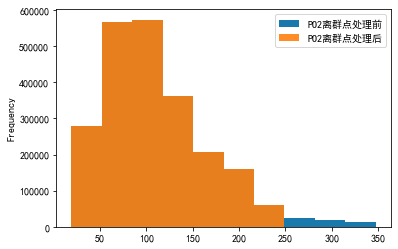

In [39]:
b.plot.hist(alpha=0.9)

对PCO2数据进行处理

In [40]:
a = pd.DataFrame()
b = pd.DataFrame()
a['PCO2'] = plo2['PCO2去噪后']
b['PCO2离群点处理前'] = a['PCO2']
# 将箱体图上下边缘的数据进行去除
first_quartile = a['PCO2'].describe()['25%']
third_quartile = a['PCO2'].describe()['75%']
iqr = third_quartile - first_quartile
b['PCO2离群点处理后'] = a[(a['PCO2'] > (first_quartile - 1.5 * iqr)) &
                    (a['PCO2'] < (third_quartile + 1.5 * iqr))]

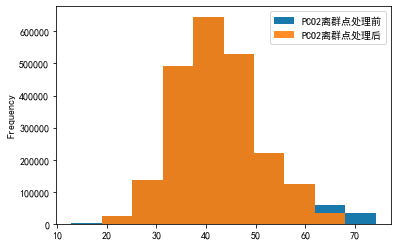

In [41]:
b.plot.hist(alpha=0.9)

## 对CHARTEVENTS表格中PO2和PCO2数据离群点进行处理

In [42]:
c = pd.DataFrame()
c['PO2'] = plo3['PO2去噪后']
c['PCO2'] = plo4['PCO2去噪后']

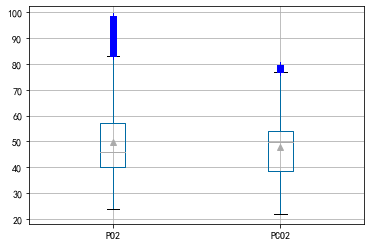

In [43]:
c.boxplot(showmeans=True, sym='b+')

对PO2数据进行处理，将箱体图上下边缘的数据进行去除

In [44]:
a = pd.DataFrame()
b = pd.DataFrame()
a['PO2'] = plo3['PO2去噪后']
b['PO2离群点处理前'] = a['PO2']
# 将箱体图上下边缘的数据进行去除
first_quartile = a['PO2'].describe()['25%']
third_quartile = a['PO2'].describe()['75%']
iqr = third_quartile - first_quartile
b['PO2离群点处理后'] = a[(a['PO2'] > (first_quartile - 1.5 * iqr)) &
                   (a['PO2'] < (third_quartile + 1.5 * iqr))]

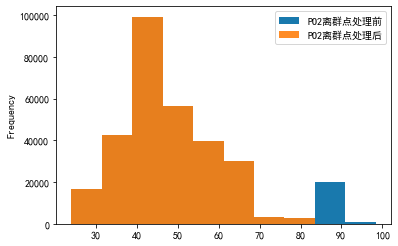

In [45]:
b.plot.hist(alpha=0.9)

对PCO2数据进行处理

In [46]:
a = pd.DataFrame()
b = pd.DataFrame()
a['PCO2'] = plo4['PCO2去噪后']
b['PCO2离群点处理前'] = a['PCO2']
# 将箱体图上下边缘的数据进行去除
first_quartile = a['PCO2'].describe()['25%']
third_quartile = a['PCO2'].describe()['75%']
iqr = third_quartile - first_quartile
b['PCO2离群点处理后'] = a[(a['PCO2'] > (first_quartile - 1.5 * iqr)) &
                    (a['PCO2'] < (third_quartile + 1.5 * iqr))]

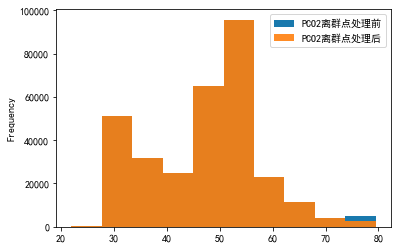

In [47]:
b.plot.hist(alpha=0.9)